# Overall Workflow
## 1. The Dataset
## 2. Preprocessing Before Modeling
## 3. Model Validation & Performance Report
## 4. Feature Importance Report
## 5. Summary

# Packages

In [1]:
# Data structures
import numpy as np
import pandas as pd

# Data formats
import csv
import json

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb

# Statistical testings
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine learning algorithms
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter tuning
from hyperopt import hp
from hyperopt import Trials
from hyperopt import tpe
from timeit import default_timer as timer
from hyperopt import STATUS_OK
from hyperopt import fmin

# Model validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

# Improvement
from imblearn.over_sampling import SMOTE

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 1. The Dataset

In [2]:
# Read in the dataset
data = pd.read_csv('banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
# 41188 data points with 21 predictors
print(data.shape)

(41188, 21)


In [4]:
# Since the purpose is to build a 'prediction' model, 
# I dropped this column from the overall feature space.
data.drop(columns='duration', inplace=True)
print(data.shape)

(41188, 20)


# 2. Preprocessing Before Modeling
- **2.1 One-hot encoding**
- **2.2 Dummy feature generation**
- **2.3 Improvement: Over-sampling using SMOTE**
- **2.4 Train & test splitting (80%/20%)**
- **2.5 Standardization**
    - Why standardization is needed? -> Regularization purpose.

## 2.1 One-hot encoding

In [5]:
dummy_features = []
binary_features = []
for each in data.columns:
    if data[each].dtype == 'object':
        if len(data[each].unique()) > 2:
            dummy_features.append(each)
        else: 
            binary_features.append(each)

In [6]:
# One-hot encoding for categorical features containing two levels.
le = LabelEncoder()
le_count = 0

for col in binary_features:
    print(col)
    le.fit(data[col])
    data[col] = le.transform(data[col])
            
    # Keep track of how many columns were label encoded
    le_count += 1
            
print('%d columns were label encoded.' % le_count)

contact
1 columns were label encoded.


In [7]:
# Make sure the transformation is correct!
# 0: cellular
# 1: telephone
data['contact'].unique()

array([0, 1])

## 2.2 Dummy feature generation

In [8]:
# Create dummy features
sum_len = 0
for col in dummy_features:
    sum_len += len(data[col].unique())
    print(col, len(data[col].unique()))
    
print('{} columns will be additionally added.'.format(sum_len - len(dummy_features)))

job 12
marital 4
education 8
default 3
housing 3
loan 3
month 10
day_of_week 5
poutcome 3
42 columns will be additionally added.


In [9]:
# Original dimension.
print(data.shape)

# 20 + 42 = 62, correct dummy feature transformation!
data = pd.get_dummies(data, columns = dummy_features)
print(data.shape)

(41188, 20)
(41188, 62)


In [10]:
data.head()

,age,contact,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,0,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,1,0,0,0,1,0
1,53,0,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,1,0,0,0,0,0,1,0
2,28,0,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1
3,39,0,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,1,0,0,0,0,0,1,0
4,55,0,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,1,0,0,0,0,0,0,1


## 2.3 Improvement: Over-sampling using SMOTE 

In [11]:
os = SMOTE(sampling_strategy='minority', k_neighbors=10, m_neighbors=20, random_state=0)
os_data_X, os_data_y = os.fit_sample(data[data.columns.difference(['y'])], 
                                     data.y)
os_data_X = pd.DataFrame(data=os_data_X, columns=data.columns.difference(['y']))
os_data_y = pd.DataFrame(data=os_data_y,columns=['y'])

# Check the numbers of over-sampled data
print("length of oversampled data is ", len(os_data_X))
print("Number of no subscription in oversampled data", len(os_data_y[os_data_y['y'] == 0]))
print("Number of subscription", len(os_data_y[os_data_y['y'] == 1]))
print("Proportion of no subscription data in oversampled data is ",
      len(os_data_y[os_data_y['y'] == 0])/len(os_data_y))
print("Proportion of subscription data in oversampled data is ",
      len(os_data_y[os_data_y['y'] == 1])/len(os_data_y))

length of oversampled data is  73096
Number of no subscription in oversampled data 36548
Number of subscription 36548
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


## 2.4 Train & test splitting (80%/20%)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(os_data_X, 
                                                    os_data_y, 
                                                    test_size=0.2, random_state=0) 

In [13]:
# Make sure the splitting is correct!
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(58476, 61) (58476, 1)
(14620, 61) (14620, 1)


## 2.5 Standardization

In [14]:
# Test data are unseen data! 
# Since my purpose is to build a prediction model,
# I shouldn't contaminate train and test data together. 
std_scaler = StandardScaler().fit(x_train)

train_standardized_data = std_scaler.transform(x_train)
test_standardized_data = std_scaler.transform(x_test)

In [15]:
# Make sure the standardization is correct (mean must be 0 and variance must be 1)!
# Train data
pd.DataFrame(train_standardized_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,...,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04
mean,-1.002020e-14,6.748655e-17,-6.869270e-14,-2.301517e-11,3.667442e-15,-3.870341e-15,-3.901273e-16,1.718602e-15,1.675090e-15,-2.863487e-15,...,-1.329894e-15,-4.945292e-16,1.779803e-15,1.507841e-15,1.183280e-11,-3.371684e-15,1.082046e-15,2.154010e-15,-1.583188e-15,-1.971310e-15
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.962015e+00,-5.680033e-01,-1.983291e+00,-2.026413e+00,-6.322546e-01,-5.095551e-01,-5.276203e-01,-5.619754e-01,-5.346215e-01,-5.361716e-01,...,-6.139690e-01,-3.350478e-01,-2.040029e-01,-1.854645e-01,-1.984152e+00,-2.851768e+00,-3.683961e-01,-1.983339e+00,-3.412183e-01,-4.575588e-01
25%,-7.633044e-01,-5.680033e-01,-4.652984e-01,-8.507732e-01,-6.322546e-01,-5.095551e-01,-5.276203e-01,-5.619754e-01,-5.346215e-01,-5.361716e-01,...,-6.139690e-01,-3.350478e-01,-2.040029e-01,-1.854645e-01,-6.875851e-01,3.529286e-01,-3.683961e-01,5.307416e-01,-3.412183e-01,-4.575588e-01
50%,-1.997150e-01,-1.843367e-01,-2.966325e-01,-5.559780e-02,-6.322546e-01,-5.095551e-01,-5.276203e-01,-5.619754e-01,-5.346215e-01,-5.361716e-01,...,-6.139690e-01,-3.350478e-01,-2.040029e-01,-1.854645e-01,6.343143e-01,3.529286e-01,-3.683961e-01,5.307416e-01,-3.412183e-01,-4.575588e-01
75%,6.394753e-01,2.584066e-01,7.153626e-01,8.164442e-01,1.645423e+00,-5.095551e-01,-4.646568e-01,5.189206e-02,-2.971104e-01,-2.754336e-01,...,1.657902e+00,-3.350478e-01,-2.040029e-01,-1.854645e-01,1.061513e+00,3.529286e-01,-3.683961e-01,5.307416e-01,-3.412183e-01,-4.575588e-01
max,4.835427e+00,2.323110e+01,2.495724e+00,2.042060e+00,1.657076e+00,2.238409e+00,2.150412e+00,2.026440e+00,2.141712e+00,2.135584e+00,...,1.657902e+00,3.104917e+00,5.185049e+00,5.793828e+00,1.061513e+00,3.529286e-01,3.026884e+00,5.307416e-01,2.984327e+00,1.018560e+01


# 3. Model Validation & Performance Report 
- **3.1 Model validation - Five-folds Cross Validation**
    - 3.1.1 Logistic Regression
    - 3.1.2 SGD Classifier
    - 3.1.3 Decision Tree
    - 3.1.4 Bagging - Decision Tree
    - 3.1.5 Random Forest
    - 3.1.6 AdaBoost
    - 3.1.7 Gradient Boosting
    - 3.1.8 XGBoost
    - 3.1.9 LightGBM
- **3.2 Model performance report**
    - 3.2.1 Logistic Regression
    - 3.2.2 SGD Classifier
    - 3.2.3 Decision Tree
    - 3.2.4 Bagging - Decision Tree
    - 3.2.5 Random Forest
    - 3.2.6 AdaBoost
    - 3.2.7 Gradient Boosting
    - 3.2.8 XGBoost
    - 3.2.9 LightGBM
- **3.3 Model performance summary**

## 3.1 Model validation - Five-folds Cross Validation

### 3.1.1 Logistic Regression

In [16]:
pd.read_csv('Bank_Marketing_LR.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'C': 899.8602591287439, 'fit_intercept': False, 'penalty': 'l1', 'random_state': 0}"],
      dtype=object)

In [17]:
lr_model = LogisticRegression(C=899.8602591287439,
                              fit_intercept=False,
                              penalty='l1',
                              random_state=0)

# Five-folds cross validation
scores = cross_validate(lr_model, train_standardized_data, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users

In [18]:
# From the five-folds cross validation result, the model (Logistic Regression) is pretty 
# steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 1
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.8014.
The standard deviation is 0.003 across five folds.
The average AUC score on train sets is 0.8022.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.2 SGD Classifier

In [19]:
pd.read_csv('Bank_Marketing_SGD.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'alpha': 0.08925428682041478, 'fit_intercept': False, 'l1_ratio': 0.5216222242414761, 'loss': 'log', 'penalty': 'l2', 'random_state': 0}"],
      dtype=object)

In [20]:
sgd_model = SGDClassifier(alpha=0.08925428682041478,
                          fit_intercept=False,
                          l1_ratio=0.5216222242414761,
                          loss='log',
                          penalty='l2',
                          random_state=0)
                        
# Five-folds cross validation
scores = cross_validate(sgd_model, train_standardized_data, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, 

In [22]:
# From the five-folds cross validation result, the model (SGD Classifier) is pretty 
# steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 2
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.7964.
The standard deviation is 0.0036 across five folds.
The average AUC score on train sets is 0.797.


### 3.1.3 Decision Tree

In [23]:
pd.read_csv('Bank_Marketing_DT.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'criterion': 'entropy', 'max_depth': 52983, 'min_samples_leaf': 0.0005254964145084773, 'min_samples_split': 0.03703819684650395, 'random_state': 0}"],
      dtype=object)

In [24]:
dt_model = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=52983,
                                  min_samples_leaf=0.0005254964145084773,
                                  min_samples_split=0.03703819684650395,
                                  random_state=0
                                 )
# Five-folds cross validation
scores = cross_validate(dt_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

In [25]:
# From the five-folds cross validation result, the model (Decision Tree) is pretty steady
# observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 3
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9193.
The standard deviation is 0.0042 across five folds.
The average AUC score on train sets is 0.9238.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.4 Bagging - Decision Tree

In [26]:
pd.read_csv('Bank_Marketing_Bag_DT.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=0,\n            splitter='best'), 'bootstrap': True, 'max_samples': 0.4290258724511593, 'n_estimators': 337, 'random_state': 0}"],
      dtype=object)

In [27]:
# Bagging requires a base learner.
base_learner = DecisionTreeClassifier(criterion='gini',
                                      max_depth=15,
                                      random_state=0)

bag_dt_model = BaggingClassifier(base_estimator=base_learner,
                                 bootstrap=True,
                                 max_samples=0.4290258724511593,
                                 n_estimators=337,
                                 random_state=0
                                 )
# Five-folds cross validation
scores = cross_validate(bag_dt_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [28]:
# From the five-folds cross validation result, the model (Bagging Decision Trees) is 
# pretty steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 4
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9743.
The standard deviation is 0.0012 across five folds.
The average AUC score on train sets is 0.9923.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.5 Random Forest

In [29]:
pd.read_csv('Bank_Marketing_RF.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 75, 'max_features': 0.6412748967722293, 'min_samples_leaf': 0.002576849681431448, 'min_samples_split': 0.0014482829188027704, 'n_estimators': 447, 'random_state': 0}"],
      dtype=object)

In [30]:
rf_model = RandomForestClassifier(criterion='entropy',
                                  n_estimators=447,
                                  max_depth=75,
                                  min_samples_leaf=0.002576849681431448,
                                  min_samples_split=0.0014482829188027704,
                                  max_features=0.6412748967722293,
                                  bootstrap=False,
                                  random_state=0)
                                  
# Five-folds cross validation
scores = cross_validate(rf_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation

In [31]:
# From the five-folds cross validation result, the model (Random Forest) is pretty steady
# observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 5
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9648.
The standard deviation is 0.0015 across five folds.
The average AUC score on train sets is 0.9712.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.6 AdaBoost

In [33]:
pd.read_csv('Bank_Marketing_AdaBoost.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=0,\n            splitter='best'), 'learning_rate': 0.013418219389796622, 'n_estimators': 466, 'random_state': 0}"],
      dtype=object)

In [34]:
base_learner = DecisionTreeClassifier(max_depth=4,random_state=0)

ada_boost_model = AdaBoostClassifier(base_estimator=base_learner,
                                     n_estimators=466,
                                     learning_rate=0.013418219389796622,
                                     random_state=0)
                                                              
# Five-folds cross validation
scores = cross_validate(ada_boost_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [35]:
# From the five-folds cross validation result, the model (AdaBoost) is pretty steady
# observed from the standard deviation of five folds. 
# However, the difference between training score and testing score is a little bit larger
# than other models.

# Model 6
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9745.
The standard deviation is 0.0008 across five folds.
The average AUC score on train sets is 0.9788.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.7 Gradient Boosting

In [37]:
pd.read_csv('Bank_Marketing_GradientBoost.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'learning_rate': 0.04853363817062756, 'max_depth': 7.323225150872149, 'max_features': 0.3744612477131876, 'n_estimators': 282, 'random_state': 0, 'subsample': 0.9758576221968132}"],
      dtype=object)

In [38]:
gradient_boost_model = GradientBoostingClassifier(n_estimators=282,
                                                  max_depth=7,
                                                  learning_rate=0.04853363817062756,
                                                  max_features=0.3744612477131876,
                                                  subsample=0.9758576221968132,
                                                  random_state=0
                                                 )                                                 
# Five-folds cross validation
scores = cross_validate(gradient_boost_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [39]:
# From the five-folds cross validation result, the model (Gradient Boosting) is 
# pretty steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 7
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9753.
The standard deviation is 0.0009 across five folds.
The average AUC score on train sets is 0.9877.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.8 XGBoost

In [40]:
pd.read_csv('Bank_Marketing_XGB.csv').sort_values(by='loss')['hyperparameters'].head(1).values

array(["{'alpha': 0.8977674804541178, 'colsample_bylevel': 0.3403161971565489, 'colsample_bynode': 0.5588001702398331, 'colsample_bytree': 0.3792154413642377, 'eta': 0.05650671213904676, 'eval_metric': 'auc', 'lambda': 0.2770442716150442, 'max_depth': 7, 'num_round': 242, 'objective': 'binary:logistic', 'subsample': 0.6179326817063491, 'task': 'train'}"],
      dtype=object)

In [41]:
xg_boost_model = xgb.XGBClassifier(objective='binary:logistic',
                                         eval_metric='auc',
                                         n_estimators=242,
                                         max_depth=7,
                                         eta=0.05650671213904676,
                                         reg_alpha=0.8977674804541178,
                                         reg_lambda=0.2770442716150442,
                                         subsample=0.6179326817063491,
                                         colsample_bylevel=0.3403161971565489,
                                         colsample_bynode=0.5588001702398331,
                                         colsample_bytree=0.3792154413642377)
                                                                                                 
# Five-folds cross validation
scores = cross_validate(xg_boost_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d arr

In [42]:
# From the five-folds cross validation result, the model (Gradient Boosting) is 
# pretty steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 8
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9747.
The standard deviation is 0.001 across five folds.
The average AUC score on train sets is 0.9854.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.9 LightGBM

In [43]:
pd.read_csv('Bank_Marketing_LightGBM.csv').sort_values(by='loss')[::-1].head(1)['hyperparameters'].values

array(["{'bagging_fraction': 0.9897832738849509, 'feature_fraction': 0.30578054896789286, 'lambda_l1': 0.9222050422501378, 'lambda_l2': 0.9762385370403396, 'learning_rate': 0.11768343418985142, 'max_depth': 7.979978808806414, 'num_iterations': 198.33014434460475}"],
      dtype=object)

In [46]:
lgb_model = lgb.LGBMClassifier(objective='binary',
                               random_state=0,
                               num_iterations=198,
                               bagging_fraction=0.9897832738849509,
                               bagging_freq=1,
                               feature_fraction=0.30578054896789286,
                               lambda_l1=0.9222050422501378,
                               lambda_l2=0.9762385370403396,
                               learning_rate=0.11768343418985142,
                               max_depth=8)
                                         
                                                                                                              
# Five-folds cross validation
scores = cross_validate(lgb_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

In [47]:
# From the five-folds cross validation result, the model (Gradient Boosting) is 
# pretty steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.

# Model 9
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9751.
The standard deviation is 0.0009 across five folds.
The average AUC score on train sets is 0.9844.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## 3.2 Model performance report

In [48]:
# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                           accuracy_score(y_train, y_train_pred>threshold),
                           precision_score(y_train, y_train_pred>threshold),
                           recall_score(y_train, y_train_pred>threshold),
                           f1_score(y_train, y_train_pred>threshold)
                          ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                          accuracy_score(y_test, y_test_pred>threshold),
                          precision_score(y_test, y_test_pred>threshold),
                          recall_score(y_test, y_test_pred>threshold),
                          f1_score(y_test, y_test_pred>threshold)
                         ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},
                               columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [49]:
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### 3.2.1 Logistic Regression

In [50]:
lr_model.fit(train_standardized_data, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=899.8602591287439, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


              train      test
metrics                      
AUC        0.802126  0.797979
Accuracy   0.744032  0.741860
Precision  0.809917  0.808146
Recall     0.637278  0.636153
f1-score   0.713301  0.711908


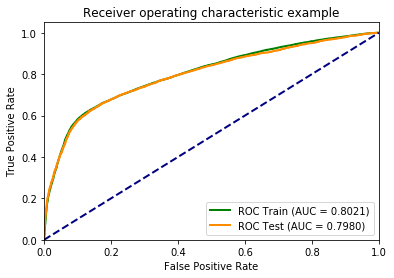

In [51]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 1
get_performance_metrics(y_train=y_train, 
                        y_train_pred=lr_model.predict_proba(train_standardized_data)[:,1], 
                        y_test=y_test, 
                        y_test_pred=lr_model.predict_proba(test_standardized_data)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=lr_model.predict_proba(train_standardized_data)[:, 1], 
               y_test=y_test, 
               y_test_pred=lr_model.predict_proba(test_standardized_data)[:,1])

In [52]:
# Model 1 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=lr_model.predict(test_standardized_data)))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      7290
           1       0.81      0.64      0.71      7330

   micro avg       0.74      0.74      0.74     14620
   macro avg       0.75      0.74      0.74     14620
weighted avg       0.75      0.74      0.74     14620



In [53]:
# Model 1 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=lr_model.predict(test_standardized_data)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,6183,1107
True 1,2667,4663


### 3.2.2 SGD Classifier

In [54]:
sgd_model.fit(train_standardized_data, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.08925428682041478, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=False,
       l1_ratio=0.5216222242414761, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.796943  0.794208
Accuracy   0.740218  0.739603
Precision  0.796191  0.796699
Recall     0.645253  0.645293
f1-score   0.712819  0.713047


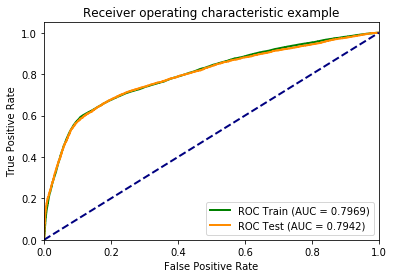

In [55]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 2
get_performance_metrics(y_train=y_train, 
                        y_train_pred=sgd_model.predict_proba(train_standardized_data)[:,1], 
                        y_test=y_test, 
                        y_test_pred=sgd_model.predict_proba(test_standardized_data)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=sgd_model.predict_proba(train_standardized_data)[:, 1], 
               y_test=y_test, 
               y_test_pred=sgd_model.predict_proba(test_standardized_data)[:,1])

In [56]:
# Model 2 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=sgd_model.predict(test_standardized_data)))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      7290
           1       0.80      0.65      0.71      7330

   micro avg       0.74      0.74      0.74     14620
   macro avg       0.75      0.74      0.74     14620
weighted avg       0.75      0.74      0.74     14620



In [57]:
# Model 2 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=sgd_model.predict(test_standardized_data)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,6083,1207
True 1,2600,4730


### 3.2.3 Decision Tree

In [58]:
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy',
            max_depth=52983, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.0005254964145084773,
            min_samples_split=0.03703819684650395,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

              train      test
metrics                      
AUC        0.923078  0.921583
Accuracy   0.860729  0.861423
Precision  0.905394  0.902795
Recall     0.805428  0.810914
f1-score   0.852490  0.854391


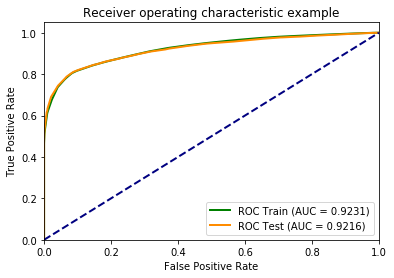

In [59]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 3
get_performance_metrics(y_train=y_train, 
                        y_train_pred=dt_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=dt_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=dt_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=dt_model.predict_proba(x_test)[:,1])

In [60]:
# Model 3 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=dt_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      7290
           1       0.90      0.81      0.85      7330

   micro avg       0.86      0.86      0.86     14620
   macro avg       0.87      0.86      0.86     14620
weighted avg       0.87      0.86      0.86     14620



In [61]:
# Model 3 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=dt_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,6650,640
True 1,1386,5944


### 3.2.4 Bagging - Decision Tree

In [62]:
bag_dt_model.fit(x_train, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.4290258724511593, n_estimators=337, n_jobs=None,
         oob_score=False, random_state=0, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.991192  0.974696
Accuracy   0.958735  0.937004
Precision  0.978609  0.955120
Recall     0.937915  0.917462
f1-score   0.957830  0.935913


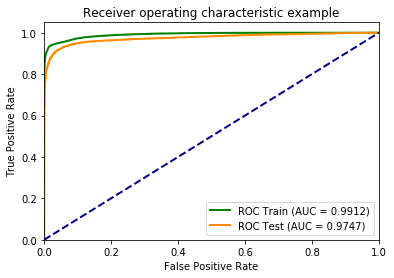

In [63]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 4
get_performance_metrics(y_train=y_train, 
                        y_train_pred=bag_dt_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=bag_dt_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=bag_dt_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=bag_dt_model.predict_proba(x_test)[:,1])

In [64]:
# Model 4 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=bag_dt_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7290
           1       0.96      0.92      0.94      7330

   micro avg       0.94      0.94      0.94     14620
   macro avg       0.94      0.94      0.94     14620
weighted avg       0.94      0.94      0.94     14620



In [65]:
# Model 4 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=bag_dt_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,6974,316
True 1,605,6725


### 3.2.5 Random Forest

In [66]:
rf_model.fit(x_train, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=75,
            max_features=0.6412748967722293, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.002576849681431448,
            min_samples_split=0.0014482829188027704,
            min_weight_fraction_leaf=0.0, n_estimators=447, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.970407  0.965816
Accuracy   0.911536  0.908071
Precision  0.928411  0.924058
Recall     0.891711  0.889768
f1-score   0.909691  0.906589


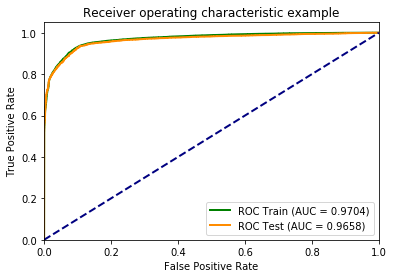

In [67]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 5
get_performance_metrics(y_train=y_train, 
                        y_train_pred=rf_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=rf_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=rf_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=rf_model.predict_proba(x_test)[:,1])

In [68]:
# Model 5 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=rf_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7290
           1       0.92      0.89      0.91      7330

   micro avg       0.91      0.91      0.91     14620
   macro avg       0.91      0.91      0.91     14620
weighted avg       0.91      0.91      0.91     14620



In [69]:
# Model 5 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=rf_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,6754,536
True 1,808,6522


### 3.2.6 AdaBoost

In [70]:
ada_boost_model.fit(x_train, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=0.013418219389796622, n_estimators=466,
          random_state=0)

              train      test
metrics                      
AUC        0.978092  0.974659
Accuracy   0.946286  0.945759
Precision  0.983212  0.981015
Recall     0.908002  0.909413
f1-score   0.944111  0.943858


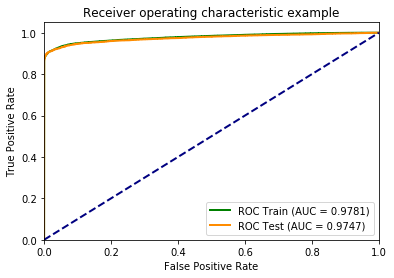

In [71]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 6
get_performance_metrics(y_train=y_train, 
                        y_train_pred=ada_boost_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=ada_boost_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=ada_boost_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=ada_boost_model.predict_proba(x_test)[:,1])

In [72]:
# Model 6 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=ada_boost_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7290
           1       0.98      0.91      0.94      7330

   micro avg       0.95      0.95      0.95     14620
   macro avg       0.95      0.95      0.95     14620
weighted avg       0.95      0.95      0.95     14620



In [73]:
# Model 6 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=ada_boost_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,7161,129
True 1,664,6666


### 3.2.7 Gradient Boosting

In [74]:
gradient_boost_model.fit(x_train, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.04853363817062756, loss='deviance',
              max_depth=7, max_features=0.3744612477131876,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=282, n_iter_no_change=None, presort='auto',
              random_state=0, subsample=0.9758576221968132, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.986369  0.975489
Accuracy   0.958855  0.944733
Precision  0.988379  0.974534
Recall     0.928571  0.913643
f1-score   0.957542  0.943107


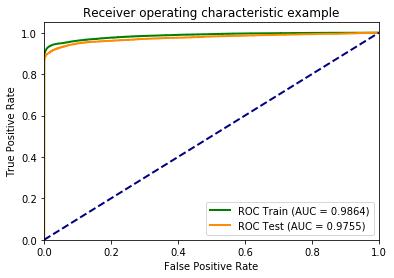

In [75]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 7
get_performance_metrics(y_train=y_train, 
                        y_train_pred=gradient_boost_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=gradient_boost_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=gradient_boost_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=gradient_boost_model.predict_proba(x_test)[:,1])

In [76]:
# Model 7 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=gradient_boost_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7290
           1       0.97      0.91      0.94      7330

   micro avg       0.94      0.94      0.94     14620
   macro avg       0.95      0.94      0.94     14620
weighted avg       0.95      0.94      0.94     14620



In [77]:
# Model 7 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=gradient_boost_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,7115,175
True 1,633,6697


### 3.2.8 XGBoost

In [78]:
xg_boost_model.fit(x_train, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.3403161971565489,
       colsample_bynode=0.5588001702398331,
       colsample_bytree=0.3792154413642377, eta=0.05650671213904676,
       eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=242,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8977674804541178, reg_lambda=0.2770442716150442,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6179326817063491)

              train      test
metrics                      
AUC        0.984146  0.974618
Accuracy   0.952288  0.944938
Precision  0.984562  0.975514
Recall     0.918920  0.913097
f1-score   0.950609  0.943274


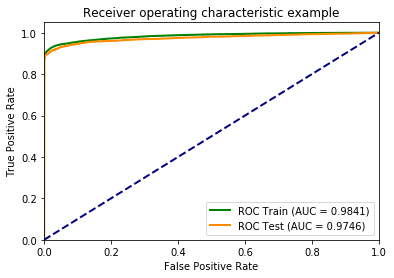

In [79]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 8
get_performance_metrics(y_train=y_train, 
                        y_train_pred=xg_boost_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=xg_boost_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=xg_boost_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=xg_boost_model.predict_proba(x_test)[:,1])

In [80]:
# Model 8 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=xg_boost_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7290
           1       0.98      0.91      0.94      7330

   micro avg       0.94      0.94      0.94     14620
   macro avg       0.95      0.95      0.94     14620
weighted avg       0.95      0.94      0.94     14620



In [81]:
# Model 8 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=xg_boost_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,7122,168
True 1,637,6693


### 3.2.9 LightGBM

In [82]:
lgb_model.fit(x_train, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.9897832738849509, bagging_freq=1,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.30578054896789286, importance_type='split',
        lambda_l1=0.9222050422501378, lambda_l2=0.9762385370403396,
        learning_rate=0.11768343418985142, max_depth=8,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_iterations=198, num_leaves=31,
        objective='binary', random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

              train      test
metrics                      
AUC        0.983263  0.974971
Accuracy   0.951040  0.945075
Precision  0.984378  0.976493
Recall     0.916558  0.912415
f1-score   0.949258  0.943367


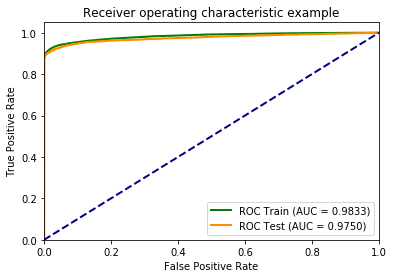

In [83]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 9
get_performance_metrics(y_train=y_train, 
                        y_train_pred=lgb_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=lgb_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=lgb_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=lgb_model.predict_proba(x_test)[:,1])

In [84]:
# Model 9 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=lgb_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7290
           1       0.98      0.91      0.94      7330

   micro avg       0.95      0.95      0.95     14620
   macro avg       0.95      0.95      0.95     14620
weighted avg       0.95      0.95      0.95     14620



In [85]:
# Model 9 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=lgb_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,7129,161
True 1,642,6688


## 3.3 Model performance summary
- I ranked all nine models based on the metric, AUC (area under the curve), since AUC provides me a flexibility to choose between precision and f1-score. 
- The bank might treat 'subscribed' customers more important than 'unsubscribed' customers because the benefits brought by the subscribed customers are more than the cost of reaching out the unsubscribed customers.
- A higher precision indicates that over all the positive predictions or over the customers have been predicted as subscribed customers, how many of them have been correctly predicted as the true subscribed customers.
- A higher recall means that over all the true subscribed customers, how many of them have been correctly predicted as the subscribed customers.
- Boosting trees including Gradient Boosting, LightGBM, and XGBoost have been ranked in the top. However, bagging decision tree ranked 3 is somehow surprised me because boosting trees usually outperform than bagging methods. Boosting trees are relatively steady in this dataset but should be noticed that overfitting issue must be addressed by including and regulating hyperparamters that could avoid the issue. Lastly, the performance difference between linear and non-linear models is huge, indicating that there are lots of interactions among predictors and a non-linear relationship existed between predictors and the response.

| Model | AUC score on test data | Rank | std of five folds | auc score difference between train and test |
| -- | -- | -- | -- | -- |
| Gradient Boosting | 0.9755 | 1 | 0.0009 (2) | 0.0124 
| LightGBM | 0.9750 | 2 | 0.0009 (2) | 0.0093
| Bagging - Decision Tree | 0.9747 | 3 | 0.0012 | 0.018
| AdaBoost | 0.9747 | 3 | 0.0008 (1) | 0.0043 (3)
| XGBoost | 0.9746 | 5 | 0.001 | 0.0107
| Random Forest | 0.9658 | 6 | 0.0015 | 0.0064
| Decision Tree | 0.9216 | 7 | 0.0042 | 0.0045
| Logistic Regression | 0.7980 | 8 | 0.003 | 0.0008 (2)
| SGD Classifier | 0.7942 | 9 | 0.0036 | 0.0006 (1)

# 4. Feature Importance Report
- **4.1 Less important features**
    - 4.1.1 Logistic Regression
    - 4.1.2 Random Forest
    - 4.1.3 Gradient Boosting
    - 4.1.4 XGBoost
    - 4.1.5 LightGBM
- **4.2 The top 10 important features**
    - 4.2.1 Logistic Regression
    - 4.2.2 Random Forest
    - 4.2.3 Gradient Boosting
    - 4.2.4 XGBoost
    - 4.2.5 LightGBM

## 4.1 Less important features
- If the coefficient of a predictor has been pushed to 0, then this predictor doesn't play any significant role in predictions.

### 4.1.1 Logistic Regression
- Since the Logistic function (sigmoid function) in the Logistic Regression is still a linear relationship between the feature and the response, I chose Logistic Regression, a linear type of machine learning models, to inspect the feature coefficients. I didn't choose the SGD Classifier, an efficient type of Logistic Regression, for the demonstration because of a lower AUC (area under the curve) score achieved on the test data.

In [86]:
i = 0
for index in abs(lr_model.coef_.flatten()).argsort():
    if lr_model.coef_.flatten()[index] == 0:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(lr_model.coef_.flatten()[index], 4)
             ))
        i+=1
print('{} coefficients of predictors were pushed to 0.'.format(i))

0 coefficients of predictors were pushed to 0.


### 4.1.2 Random Forest
- Contrast to the Logistic Regression, tree-based models such as Random Forest and Boosting trees produce a feature importance rank list but without the linear relationship existed because tree-based models learn the pattern between predictors and the response as a 'non-linear' function.

In [87]:
# Seven predictors have no contribution on the response variable.
pd.DataFrame(rf_model.feature_importances_[rf_model.feature_importances_ == 0],
             index = x_train.columns[rf_model.feature_importances_ == 0],
             columns=['importance by Random Forest'])

,importance by Random Forest
default_yes,0.0
education_illiterate,0.0
job_student,0.0
job_unemployed,0.0
job_unknown,0.0
marital_unknown,0.0
month_dec,0.0


### 4.1.3 Gradient Boosting

In [88]:
# No predictors have no contribution on the response variable.
pd.DataFrame(gradient_boost_model.feature_importances_[gradient_boost_model.feature_importances_ == 0],
             index = x_train.columns[gradient_boost_model.feature_importances_ == 0],
             columns=['importance by Gradient Boosting'])

,importance by Gradient Boosting


### 4.1.4 Xgboost

In [89]:
# Only one predictor has no contribution on the response variable.
pd.DataFrame(xg_boost_model.feature_importances_[xg_boost_model.feature_importances_ == 0],
             index = x_train.columns[xg_boost_model.feature_importances_ == 0],
             columns=['importance by xgboost'])

,importance by xgboost
default_yes,0.0


### 4.1.5 LightGBM

In [90]:
# Only one predictor has no contribution on the response variable.
pd.DataFrame(lgb_model.feature_importances_[lgb_model.feature_importances_ == 0],
             index = x_train.columns[lgb_model.feature_importances_ == 0],
             columns=['importance by xgboost'])

,importance by xgboost
default_yes,0


## 4.2 The top 10  important features

### 4.2.1 Logistic Regression

In [91]:
# The top 5 important negative predictors.
i = 0
for index in lr_model.coef_.flatten().argsort():
    if lr_model.coef_.flatten()[index] != 0 and i<5:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(lr_model.coef_.flatten()[index], 4)),
             np.exp(lr_model.coef_.flatten()[index]))
        i+=1

Coefficient of column default_yes is -18.8329. 6.622094687780281e-09
Coefficient of column emp_var_rate is -2.868. 0.05681005277022172
Coefficient of column pdays is -0.4418. 0.6428957145269447
Coefficient of column contact is -0.3573. 0.6995847390203581
Coefficient of column month_jun is -0.2084. 0.8118894241641711


In [92]:
# The top 5 important positive predictors.
i = 0
for index in lr_model.coef_.flatten().argsort()[::-1]:
    if lr_model.coef_.flatten()[index] != 0 and i<5:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(lr_model.coef_.flatten()[index], 4)),
             np.exp(lr_model.coef_.flatten()[index]))
        i+=1

Coefficient of column cons_price_idx is 1.4647. 4.326396803678596
Coefficient of column nr_employed is 0.6766. 1.9670942542671932
Coefficient of column euribor3m is 0.5042. 1.655635597635104
Coefficient of column month_aug is 0.2911. 1.3379627995660415
Coefficient of column month_mar is 0.2881. 1.333908795723189


#### Increasing the feature value by 1 decreases logit odds by theta and odds by the exponential of theta.

| Negative Feature |$$\theta$$| $$e^\theta$$ |
| - | - | - |
| default_yes | -18.8329 | 6.622094687780281e-09 |
| emp_var_rate | -2.868 | 0.0568 |
| pdays | -0.4418 | 0.6429 | 
| contact | -0.3573 | 0.6996 | 
| month_jun | -0.2084 | 0.8119 |

#### Increasing the feature value by 1 increases logit odds by theta and odds by the exponential of theta.

| Positive Feature |$$\theta$$| $$e^\theta$$ |
| - | - | - |
| cons_price_idx | 1.4647 | 4.3264 |
| nr_employed | 0.6766 | 1.9671 |
| euribor3m | 0.5042 | 1.6556 | 
| month_aug | 0.2911 | 1.3380 | 
| month_mar | 0.2881 | 1.3339 |

#### Recommendations
- Nagative Features
    - Uncontrollable Factors
        - default_yes: credit has in default. -> If a customer has the credit in default, then the lower probability of a term deposit subscription she or he has.
        - emp_var_rate: employment variation rate - quarterly indicator. -> The lower the employment variation rate is, the higher the probability of a term deposit subscription occurs.
    - Controllable Factors
        - pdays: number of days that passed by after the client was last contacted from a previous campaign. -> **The less, the better. The closer the days that passed by after the client was last contacted from a previous campaign, the higher the probability of subscribing the term deposit.**
        - contact: contact communication type (0: 'cellular', 1: 'telephone'). -> **Clients contacted by the cellular tended to subscribe term deposits.**
        - month_jun: last contact month of year. -> **The last time when clients contacted on June were less likely to subscribe term deposits.** 
 
- Positive Features
    - Uncontrollable Factors
        - cons_price_idx (CPI): consumer price index - monthly indicator. -> The higher the consumer price index is, the higher the probability of a term deposit subscription is.
        - nr_employed: number of employees. -> Same as cons_price_idx.
        - euribor3m: euribor 3 month rate - daily indicator. -> Same as cons_price_idx.
    - Controllable Factors
        - month_aug: last contact month of year. -> **The last time clients contacted on August were more likely to subscribe term deposits.**
        - month_mar: last contact month of year. -> **The last time clients contacted on March were more likely to subscribe term deposits.**

### 4.2.2 Random Forest

In [93]:
# Top 10 important features by Random Forest.
rf_top_ten_f = pd.DataFrame(rf_model.feature_importances_,
                            index = x_train.columns,
                            columns=['importance']).sort_values('importance',ascending=False).head(10)
rf_top_ten_f

,importance
nr_employed,0.179790
euribor3m,0.075981
day_of_week_wed,0.058705
day_of_week_tue,0.056656
day_of_week_thu,0.055927
emp_var_rate,0.050219
contact,0.047496
education_university.degree,0.046761
day_of_week_mon,0.041291
cons_conf_idx,0.038084


### 4.2.3 Gradient Boosting

In [94]:
# Top 10 important features by Gradient Boosting.
gb_top_ten_f = pd.DataFrame(gradient_boost_model.feature_importances_,
                            index = x_train.columns,
                            columns=['importance']).sort_values('importance',ascending=False).head(10)
gb_top_ten_f

,importance
nr_employed,0.131123
euribor3m,0.092466
contact,0.059486
education_university.degree,0.042596
day_of_week_wed,0.042284
day_of_week_fri,0.041907
day_of_week_mon,0.039240
job_admin.,0.035576
day_of_week_thu,0.034291
cons_conf_idx,0.032711


### 4.2.4 XGBoost

In [95]:
# Top 10 important features by XGBoost.
xgb_top_ten_f = pd.DataFrame(xg_boost_model.feature_importances_,
                             index = x_train.columns,
                             columns=['importance']).sort_values('importance',ascending=False).head(10)
xgb_top_ten_f

,importance
age,0.077570
euribor3m,0.070209
campaign,0.054437
cons_conf_idx,0.048775
cons_price_idx,0.042627
nr_employed,0.031303
emp_var_rate,0.028310
marital_married,0.024509
housing_yes,0.023781
education_university.degree,0.021758


### 4.2.5 LightGBM
- The feature importance result doesn't sum up to 1 by the LightGBM. Thus a transformation has been done for a fair comparison among other tree-based models.

In [96]:
# Top 10 important features by LightGBM.
lgbm_top_ten_f = pd.DataFrame({'importance': lgb_model.feature_importances_,
                               '% importance': lgb_model.feature_importances_/sum(lgb_model.feature_importances_)},
                              index = x_train.columns).sort_values('importance',ascending=False).head(10)
lgbm_top_ten_f

,importance,% importance
euribor3m,677,0.114088
age,607,0.102292
campaign,327,0.055106
cons_price_idx,290,0.048871
cons_conf_idx,279,0.047017
nr_employed,153,0.025784
day_of_week_thu,149,0.025110
previous,146,0.024604
pdays,140,0.023593
emp_var_rate,138,0.023256


#### Summary

Text(0.5, 1.0, 'LightGBM, AUC: 0.9750(2)')

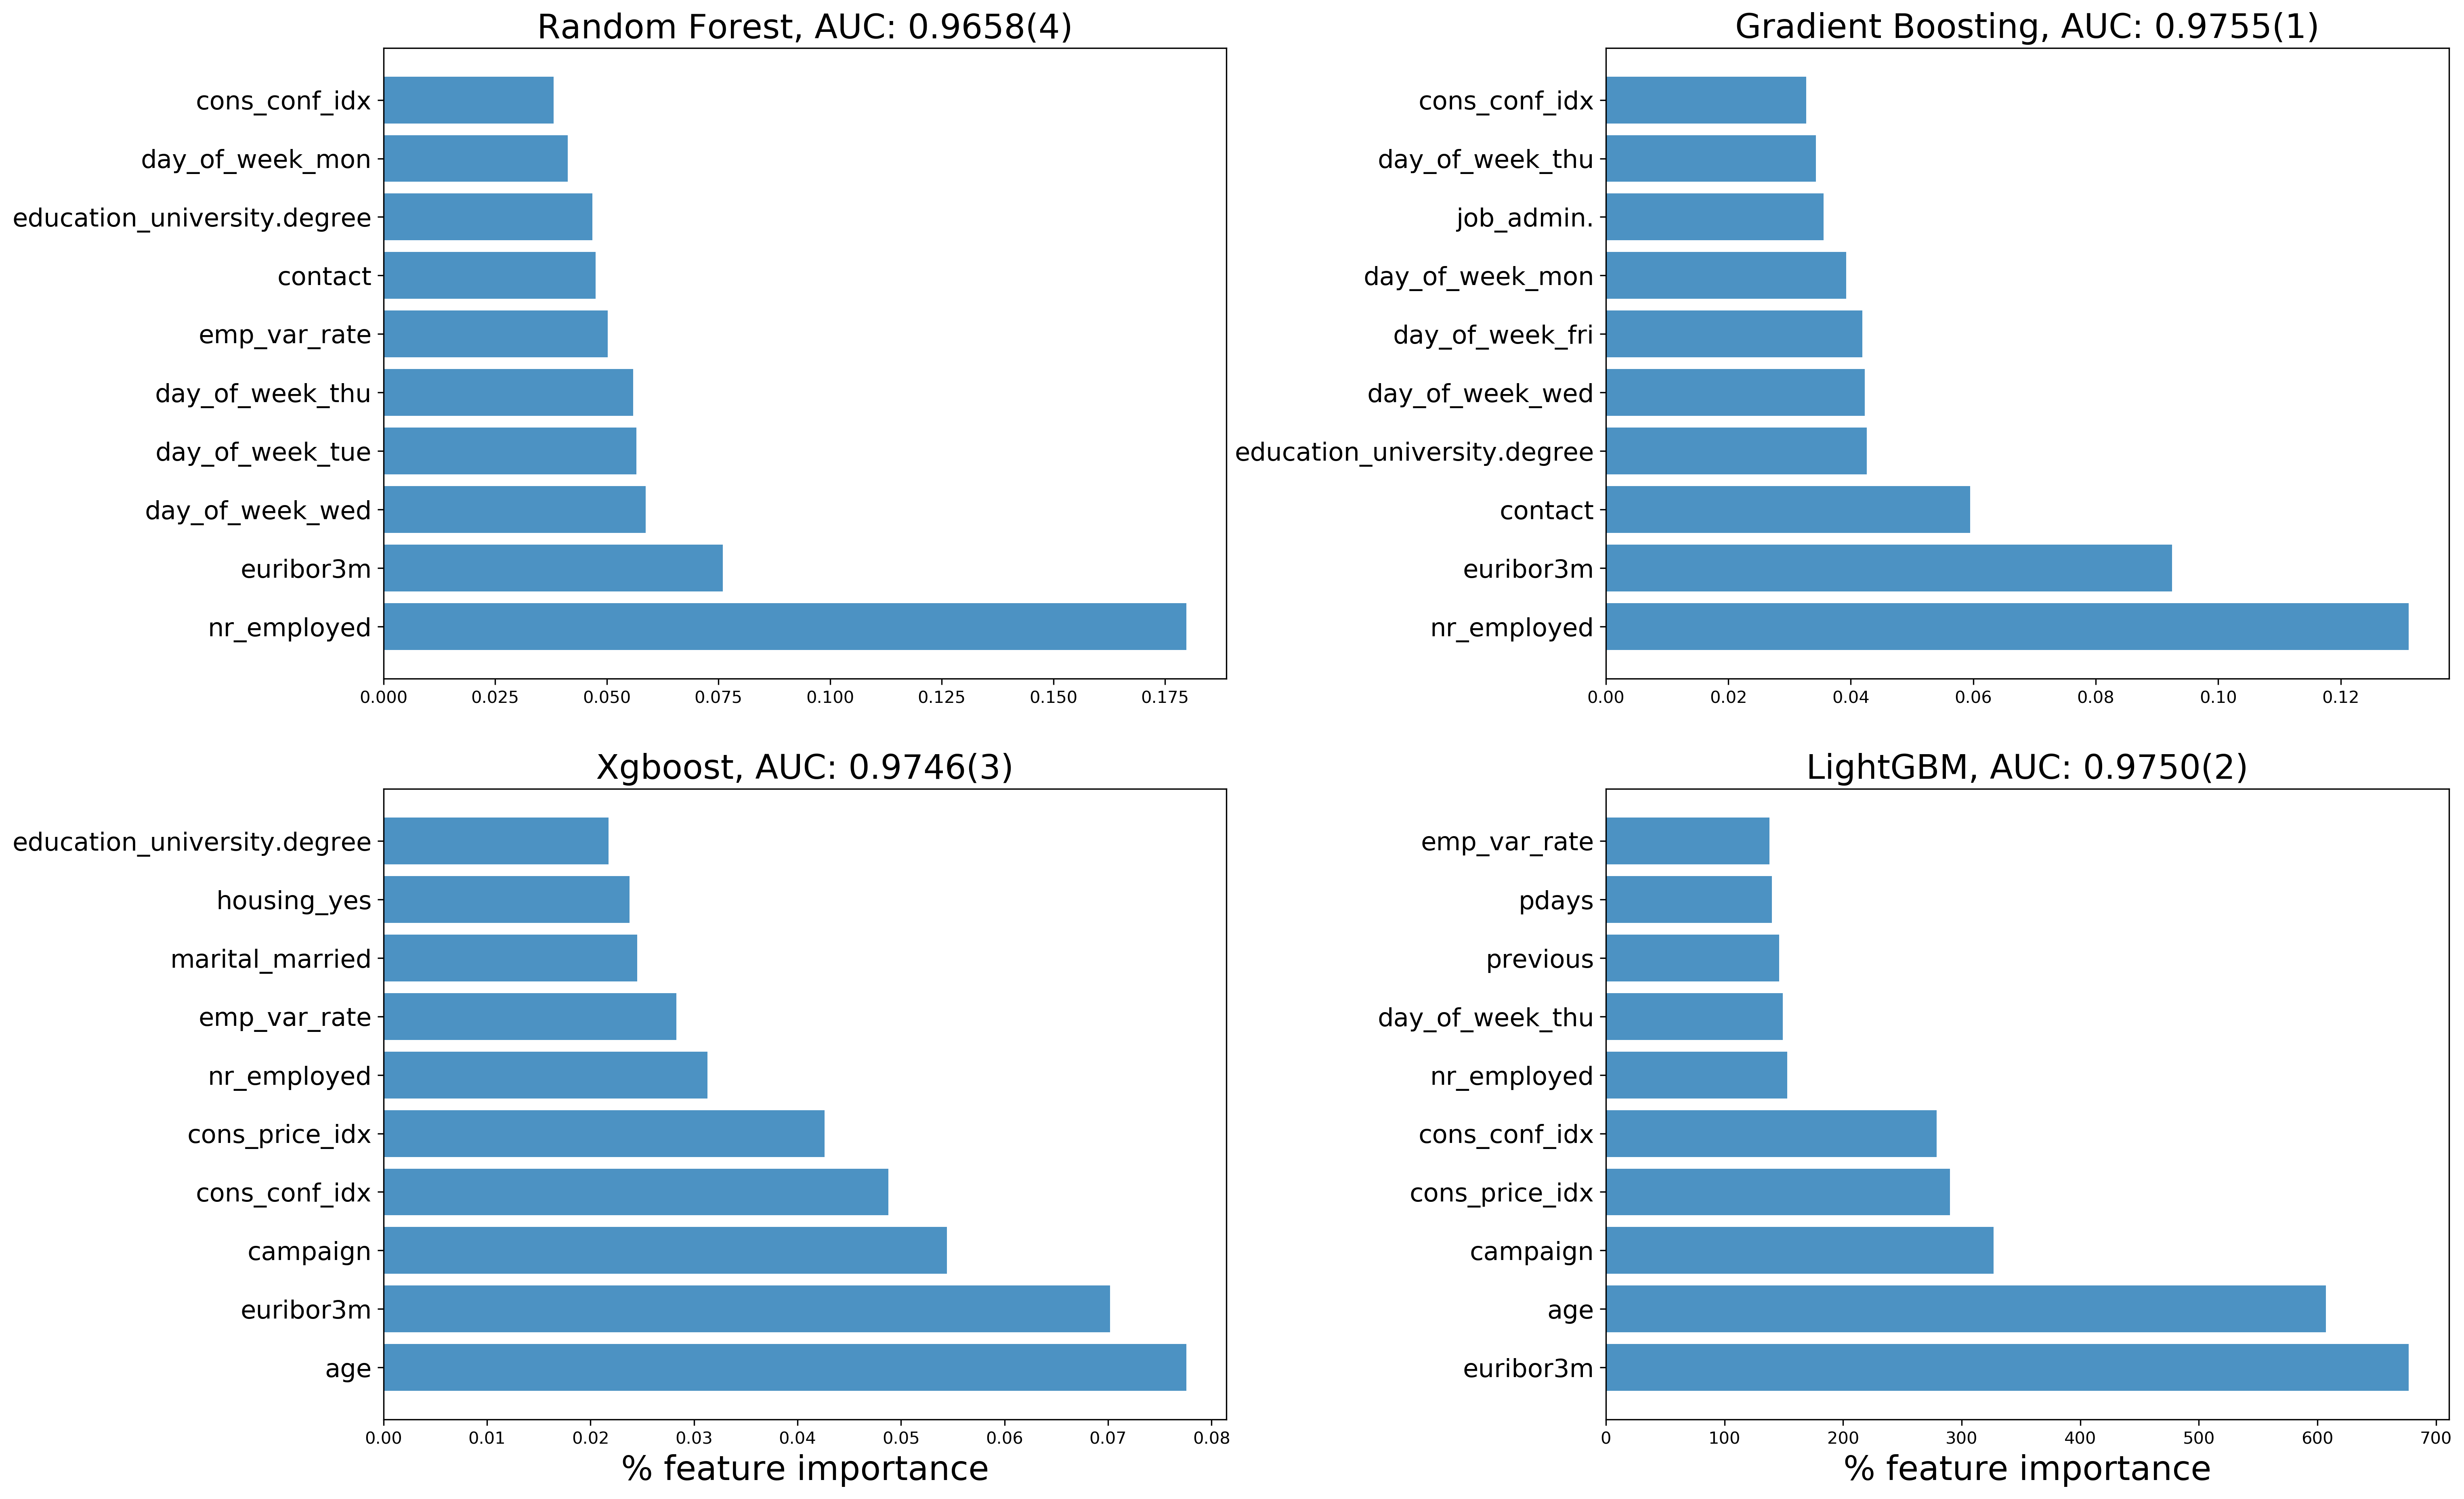

In [97]:
fig = plt.figure(figsize=(22,15), dpi=300)
fig.subplots_adjust(hspace=0.175, wspace=0.45)

plt.subplot(221)
plt.barh(np.arange(10), rf_top_ten_f['importance'].values, align='center', alpha=0.8)
plt.yticks(np.arange(10), rf_top_ten_f.index, fontsize=15)
plt.title('Random Forest, AUC: 0.9658(4)',fontsize=20)
    
plt.subplot(222)
plt.barh(np.arange(10), gb_top_ten_f['importance'].values, align='center', alpha=0.8)
plt.yticks(np.arange(10), gb_top_ten_f.index, fontsize=15)
plt.title('Gradient Boosting, AUC: 0.9755(1)',fontsize=20)

plt.subplot(223)
plt.barh(np.arange(10), xgb_top_ten_f['importance'].values, align='center', alpha=0.8)
plt.yticks(np.arange(10), xgb_top_ten_f.index, fontsize=15)
plt.xlabel('% feature importance',fontsize=20)
plt.title('Xgboost, AUC: 0.9746(3)',fontsize=20)

plt.subplot(224)
plt.barh(np.arange(10), lgbm_top_ten_f['importance'].values, align='center', alpha=0.8)
plt.yticks(np.arange(10), lgbm_top_ten_f.index, fontsize=15)
plt.xlabel('% feature importance',fontsize=20)
plt.title('LightGBM, AUC: 0.9750(2)',fontsize=20)

In [98]:
# Append top 10 features provided by each model into a list.
top_ten_f = []
for each in rf_top_ten_f.index.values:
    top_ten_f.append(each)
for each in gb_top_ten_f.index.values:
    top_ten_f.append(each)
for each in xgb_top_ten_f.index.values:
    top_ten_f.append(each)
for each in lgbm_top_ten_f.index.values:
    top_ten_f.append(each) 

In [99]:
# 40 features provided by 4 models.
len(top_ten_f)

40

In [100]:
# Majority vote: if a feature was ranked in the top 10 list four times, 
# then it is a very important feature!
dic_top_ten_f = {}
for each in top_ten_f:
    if each not in dic_top_ten_f:
        dic_top_ten_f[each] = 1
    else:
        dic_top_ten_f[each] += 1

In [101]:
# Sorted by the values.
for key, value in sorted(dic_top_ten_f.items(), key=lambda x: x[1], reverse=True):
    print("%s: %s" % (key, value))

nr_employed: 4
euribor3m: 4
cons_conf_idx: 4
day_of_week_thu: 3
emp_var_rate: 3
education_university.degree: 3
day_of_week_wed: 2
contact: 2
day_of_week_mon: 2
age: 2
campaign: 2
cons_price_idx: 2
day_of_week_tue: 1
day_of_week_fri: 1
job_admin.: 1
marital_married: 1
housing_yes: 1
previous: 1
pdays: 1


#### Recommendations by four tree-based models
- Features have been voted **four times**
    - Uncontrollable Factors
        - nr_employed: number of employees.
        - euribor3m: euribor 3 month rate - daily indicator.
        - cons_price_idx (CPI): consumer price index - monthly indicator.
- Features have been voted **three times** 
    - Uncontrollable Factors
        - emp_var_rate: employment variation rate - quarterly indicator. 
        - education_university.degree
    - Controllable Factors
        - day_of_week_thu: last contact day of the week.

# 5. Summary
- **For an efficient marketing campaign, I recommend the bank should reach out to the potential clients by following strategies (bolded strategies consider first):**
    - Contact clients with age from 17 to 38 years old.
    - **Contact clients who earned university degrees.**
    - Contact clients who have housing loans.
    - **Contact clients on Thursday.**
    - Contact clients by their cellulars.
    - Contact clients who until now have been contacted less than twice for this campaign.
    - Contact clients who have contacted before this campaign less than twice (from 0 to 2) and the contact day difference between the current and previous campaign should be less than 6 (as close as possible).

## Education: University degree
- **3% more customers who earned university degrees subscribed to term deposits compared with customers who don't have university degrees.**

In [321]:
# Proportion of subscribed customers (label = 1) who don't have university degrees.
print((data[data['education_university.degree'] == 0]['y'].value_counts() / 
       sum(data[data['education_university.degree'] == 0]['y'].value_counts())))

# Proportion of subscribed customers who earned university degrees. 
print((data[data['education_university.degree'] == 1]['y'].value_counts() / 
       sum(data[data['education_university.degree'] == 1]['y'].value_counts())))

0    0.897657
1    0.102343
Name: y, dtype: float64
0    0.862755
1    0.137245
Name: y, dtype: float64


## Weekday: Thursday
- **1% more customers who were contacted on Thursday subscribed to term deposits compared with customers who were contacted on days rather than on Thursday.**

In [322]:
# Proportion of subscribed customers who were contacted on days rather than on Thursday.
print((data[data['day_of_week_thu'] == 0]['y'].value_counts() / 
       sum(data[data['day_of_week_thu'] == 0]['y'].value_counts())))

# Proportion of subscribed customers who were contacted on Thursday.
print((data[data['day_of_week_thu'] == 1]['y'].value_counts() / 
       sum(data[data['day_of_week_thu'] == 1]['y'].value_counts())))

0    0.889605
1    0.110395
Name: y, dtype: float64
0    0.878812
1    0.121188
Name: y, dtype: float64


## Contact
- **9% more customers who were contacted by celluars subscribed to term deposits compared with customers who were contacted by telephones.**

In [323]:
# Proportion of subscribed customers who were contacted by celluars.
print(data[data['contact'] == 0]['y'].value_counts() / 
      sum(data[data['contact'] == 0]['y'].value_counts()))

# Proportion of subscribed customers who were contacted by telephones.
print(data[data['contact'] == 1]['y'].value_counts() / 
      sum(data[data['contact'] == 1]['y'].value_counts()))

0    0.852624
1    0.147376
Name: y, dtype: float64
0    0.947687
1    0.052313
Name: y, dtype: float64


## Age
- **1% more customers who are young or from 17 to 38 years old subscribed to term deposits compared with customers who are old or more than 38 years old.**

In [324]:
# Find the median value.
# I pick median value as a boundary line to distinguish between young and old people.
data['age'].describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

In [325]:
# Proportion of subscribed customers who are old.
print(data[data['age'] > 38]['y'].value_counts() / 
      sum(data[data['age'] > 38]['y'].value_counts()))

# Proportion of subscribed customers who are young.
print(data[data['age'] <= 38]['y'].value_counts() / 
      sum(data[data['age'] <= 38]['y'].value_counts()))

0    0.894219
1    0.105781
Name: y, dtype: float64
0    0.88085
1    0.11915
Name: y, dtype: float64


Text(0.5, 1.0, 'Distribution of age')

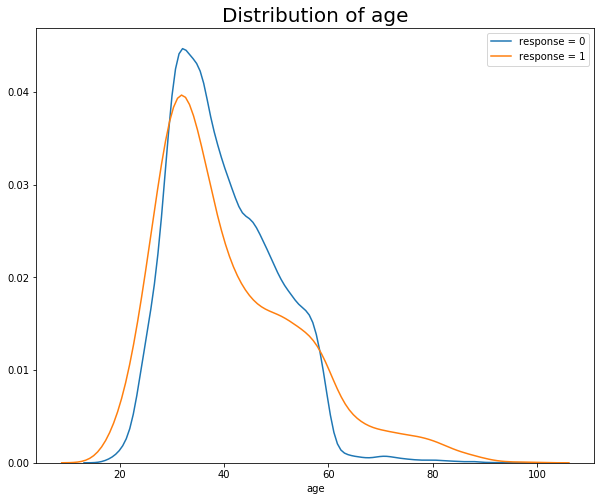

In [326]:
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['y'] == 0, 'age'], label = 'response = 0')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['y'] == 1, 'age'], label = 'response = 1')

# Labeling
plt.xlabel('age')
plt.title('Distribution of '+ 'age', fontsize=20)

## Campaign
- **3.7% more customers who have been contacted less than twice for this campaign subscribed to term deposits compared with customers who have been contacted more than twice for this campaign.**

In [327]:
# Find the median value.
data['campaign'].describe()

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

In [328]:
# Proportion of subscribed customers who have been contacted more than twice for this campaign.
print(data[data['campaign'] > 2]['y'].value_counts() / 
      sum(data[data['campaign'] > 2]['y'].value_counts()))

# Proportion of subscribed customers who have been contacted less than twice for this campaign.
print(data[data['campaign'] <= 2]['y'].value_counts() / 
      sum(data[data['campaign'] <= 2]['y'].value_counts()))

0    0.912993
1    0.087007
Name: y, dtype: float64
0    0.875549
1    0.124451
Name: y, dtype: float64


## Housing
- **0.7% more customers who have housing loans subscribed to term deposits compared with customers who don't have housing loans.**

In [329]:
# Proportion of subscribed customers who have housing loans.
print(data[data['housing_yes'] == 1]['y'].value_counts() / 
      sum(data[data['housing_yes'] == 1]['y'].value_counts()))

# Proportion of subscribed customers who don't have housing loans.
print(data[data['housing_yes'] == 0]['y'].value_counts() / 
      sum(data[data['housing_yes'] == 0]['y'].value_counts()))

0    0.883806
1    0.116194
Name: y, dtype: float64
0    0.89124
1    0.10876
Name: y, dtype: float64


## Previous
- **17% more customers who have already been contacted at least once before this campaign subscribed to term deposits compared with customers who don't have been contacted.**
- **However, the bank shouldn't contact customers 'too' many times because it would affect their willingness to subscribe. My suggestion for the number of previous contact would be from 0 to 2.**

In [330]:
# Find the median value.
data['previous'].describe()

count    41188.000000
mean         0.172963
std          0.494901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64

In [331]:
# Proportion of subscribed customers who don't have been contacted.
# before this campaign.
print(data[data['previous'] == 0]['y'].value_counts() / 
      sum(data[data['previous'] == 0]['y'].value_counts()))

# Proportion of subscribed customers who have already been contacted at least once 
# before this campaign.
print(data[data['previous'] != 0]['y'].value_counts() / 
      sum(data[data['previous'] != 0]['y'].value_counts()))

0    0.911678
1    0.088322
Name: y, dtype: float64
0    0.733511
1    0.266489
Name: y, dtype: float64


In [332]:
# The mean value of previous of subscribed customers is higher than 
# customers who didn't subscribe. 
# However, it doesn't indicate the bank should contact customers "as many time as it can"!
print(data[data.y == 0]['previous'].describe())
print(data[data.y == 1]['previous'].describe())

count    36548.000000
mean         0.132374
std          0.409199
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64
count    4640.000000
mean        0.492672
std         0.860344
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: previous, dtype: float64


Text(0.5, 1.0, 'Distribution of previous')

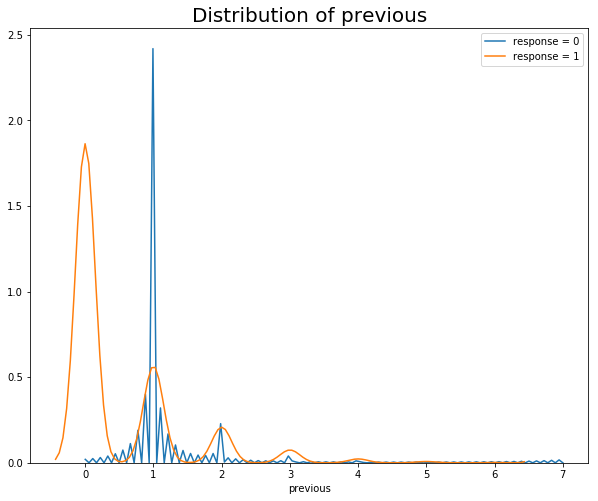

In [333]:
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['y'] == 0, 'previous'], label = 'response = 0')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['y'] == 1, 'previous'], label = 'response = 1')

# Labeling
plt.xlabel('previous')
plt.title('Distribution of '+ 'previous', fontsize=20)

## pdays
- **25% more customers who have already been contacted previously subscribed to term deposits compared with customers who don't have been contacted.**
- **Number of days that passed by after the client was last contacted from a previous campaign should be no more than 6 days**.

In [334]:
# Find the median value.
data['pdays'].describe()

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64

In [335]:
# 999 pdays means that customers were not previously contacted.
# Customers contacted previously seem to subscribe, but how frequently it should be?
print(data[data['pdays'] == 999]['y'].value_counts() / 
      sum(data[data['pdays'] == 999]['y'].value_counts()))

print(data[data['pdays'] != 999]['y'].value_counts() / 
      sum(data[data['pdays'] != 999]['y'].value_counts()))

0    0.907418
1    0.092582
Name: y, dtype: float64
1    0.638284
0    0.361716
Name: y, dtype: float64


In [336]:
# Exclude 999 pdays to avoid biased mean values.
# Number of days contacted before this campaign should be less than 6.
# If pdays is too large, then it might affect the willingness to subscribe.
print(data[(data.y == 0) & (data.pdays != 999)]['pdays'].describe())
print(data[(data.y == 1) & (data.pdays != 999)]['pdays'].describe())

count    548.000000
mean       6.193431
std        3.987525
min        0.000000
25%        3.000000
50%        6.000000
75%        9.000000
max       22.000000
Name: pdays, dtype: float64
count    967.000000
mean       5.913133
std        3.727896
min        0.000000
25%        3.000000
50%        6.000000
75%        6.000000
max       27.000000
Name: pdays, dtype: float64


Text(0.5, 1.0, 'Distribution of pdays')

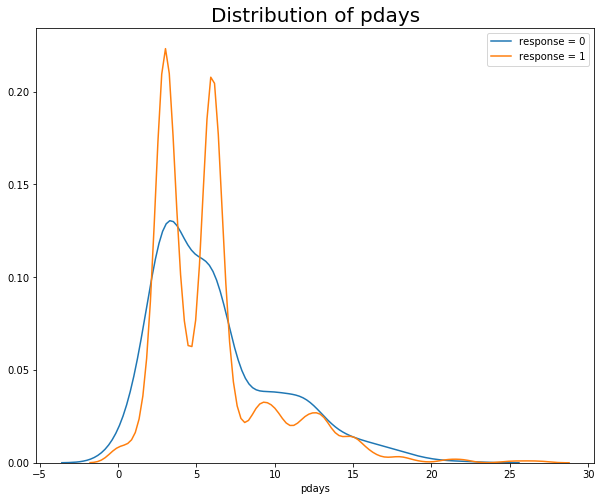

In [337]:
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data[(data.y == 0) & (data.pdays != 999)]['pdays'], label = 'response = 0')
    
# KDE plot of y = 1 
sb.kdeplot(data[(data.y == 1) & (data.pdays != 999)]['pdays'], label = 'response = 1')

# Labeling
plt.xlabel('pdays')
plt.title('Distribution of '+ 'pdays', fontsize=20)